# Labolatorium 1 - Dopasowanie wzorca do tesktu

## Import bibliotek oraz ich konfiguracja

In [1]:
import time
from enum import Enum
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Implementacja algorytmów wyszukiwania wzorców

### Algorytm naiwny

In [2]:
def naive_string_matching(text, pattern):
    pattern_occurences = []
    for s in range(0, len(text) - len(pattern) + 1):
        if text[s:s+len(pattern)] == pattern:
            pattern_occurences.append(s)

    return pattern_occurences

### Algorytm KMP

In [3]:
def prefix_function(pattern):
    pi = [0]
    k = 0
    for q in range(1, len(pattern)):
        while k > 0 and pattern[k] != pattern[q]:
            k = pi[k-1]
        if pattern[k] == pattern[q]:
            k += 1
        pi.append(k)
    return pi

def kmp_string_matching(text, pattern, pi=None):
    if pi is None:
        pi = prefix_function(pattern)
        
    q = 0
    pattern_occurences = []
    for i in range(len(text)):
        while q > 0 and pattern[q] != text[i]:
            q = pi[q-1]
        if pattern[q] == text[i]:
            q += 1
        if q == len(pattern):
            pattern_occurences.append(i - q + 1)
            q = pi[q-1]
    return pattern_occurences

### Automat skończony

In [4]:
def transition_table(pattern):
    alphabet = set(pattern)
    table = []
    for q in range(len(pattern)+1):
        table.append({})
        for a in alphabet:
            k = min(len(pattern), q+1)
            while True:
                # x[:k] - k length prefix              
                # # x[-k:] - k length suffix
                if k == 0 or pattern[:k] == (pattern[:q] + a)[-k:]:
                    break
                k -= 1
            table[q][a] = k
    return table            

def fa_string_matching(text, pattern, delta=None):
    q = 0
    if delta is None:
        delta = transition_table(pattern)
    pattern_occurences = []
    for s in range(len(text)):
        if text[s] in delta[q]:
            q = delta[q][text[s]]
            if q == len(delta) - 1:
                pattern_occurences.append(s+1-q)
        else:
            q = 0
    return pattern_occurences

## Testy porównujące szybkość działania algorytmów

In [5]:
class Algorithm(Enum):
    NAIVE = 1
    KMP = 2
    FA = 3

    def __str__(self):
        if self == Algorithm.NAIVE:
            return "Naive"
        if self == Algorithm.KMP:
            return "KMP"
        if self == Algorithm.FA:
            return "Finite Automata"

def measure_execution_time(algorithm, text, pattern):
    if algorithm == Algorithm.NAIVE:
        start = time.perf_counter()
        naive_string_matching(text, pattern)
        end = time.perf_counter()
        return None, end - start
    
    if algorithm == Algorithm.KMP:
        pre_start = time.perf_counter()
        table = prefix_function(pattern)
        pre_end = time.perf_counter()
        start = time.perf_counter()
        kmp_string_matching(text, pattern, table)
        end = time.perf_counter()
        return pre_end - pre_start, end - start
    
    if algorithm == Algorithm.FA:
        pre_start = time.perf_counter()
        table = transition_table(pattern)
        pre_end = time.perf_counter()
        start = time.perf_counter()
        fa_string_matching(text, pattern, table)
        end = time.perf_counter()
        return pre_end - pre_start, end - start


## Znalezienie wszystkich wystąpień wzorców "pan" oraz "pani" w załączonym pliku, za pomocą każdego algorytmu

In [6]:
# Read file with text
with open("pan-tadeusz.txt", "r") as f:
    text = f.read()
    
print(pd.DataFrame({
    "Naive": [len(naive_string_matching(text, "pan")), len(naive_string_matching(text, "pani"))],
    "KMP": [len(kmp_string_matching(text, "pan")), len(kmp_string_matching(text, "pani"))],
    "FA": [len(fa_string_matching(text, "pan")), len(fa_string_matching(text, "pani"))]
}, index=["pan", "pani"]))

      Naive  KMP   FA
pan     401  401  401
pani    100  100  100


## Porównanie czasu działania algorytmów dla poprzedniego zadania

In [7]:
def show_algorithm_times(text, pattern):
    index = ["Naive", "KMP pre-processing", "KMP", "KMP with preprocessing", "FA pre-processing",  "FA", "FA with preprocessing"]
    tries = 10

    # Execute algorithms
    naive_executions = [(i, measure_execution_time(Algorithm.NAIVE, text, pattern)) for i in range(tries)]
    kmp_executions = [(i, measure_execution_time(Algorithm.KMP, text, pattern)) for i in range(tries)]
    fa_executions = [(i, measure_execution_time(Algorithm.FA, text, pattern)) for i in range(tries)]

    # Prepare data

    minimum_times = []
    maximum_times = []
    average_times = []

    minimum_times.append(min([time[1][1] for time in naive_executions]))
    minimum_times.append(min([time[1][0] for time in kmp_executions]))
    minimum_times.append(min([time[1][1] for time in kmp_executions]))
    minimum_times.append(min([sum(time[1]) for time in kmp_executions]))
    minimum_times.append(min([time[1][0] for time in fa_executions]))
    minimum_times.append(min([time[1][1] for time in fa_executions]))
    minimum_times.append(min([sum(time[1]) for time in fa_executions]))

    maximum_times.append(max([time[1][1] for time in naive_executions]))
    maximum_times.append(max([time[1][0] for time in kmp_executions]))
    maximum_times.append(max([time[1][1] for time in kmp_executions]))
    maximum_times.append(max([sum(time[1]) for time in kmp_executions]))
    maximum_times.append(max([time[1][0] for time in fa_executions]))
    maximum_times.append(max([time[1][1] for time in fa_executions]))
    maximum_times.append(max([sum(time[1]) for time in fa_executions]))

    average_times.append(sum([time[1][1] for time in naive_executions]) / tries)
    average_times.append(sum([time[1][0] for time in kmp_executions]) / tries)
    average_times.append(sum([time[1][1] for time in kmp_executions]) / tries)
    average_times.append(sum([sum(time[1]) for time in kmp_executions]) / tries)
    average_times.append(sum([time[1][0] for time in fa_executions]) / tries) 
    average_times.append(sum([time[1][1] for time in fa_executions]) / tries)
    average_times.append(sum([sum(time[1]) for time in fa_executions]) / tries)

    # Statistics for naive algorithm
    naive_minimum_point = min(naive_executions, key=lambda x: x[1][1])
    naive_maximum_point = max(naive_executions, key=lambda x: x[1][1])

    # Statistics for KMP algorithm
    kmp_minimum_point = min(kmp_executions, key=lambda x: sum(x[1]))
    kmp_maximum_point = max(kmp_executions, key=lambda x: sum(x[1]))

    # Statistics for FA algorithm
    fa_minimum_point = min(fa_executions, key=lambda x: sum(x[1]))
    fa_maximum_point = max(fa_executions, key=lambda x: sum(x[1]))

    l1 = plt.plot(list(map(lambda x: x[1][1], naive_executions)), label="Naive")
    l2 = plt.plot(list(map(lambda x: sum(x[1]), kmp_executions)), label="KMP")
    l3 = plt.plot(list(map(lambda x: sum(x[1]), fa_executions)), label="FA")
    # Average time
    l4 = plt.axhline(y=average_times[0], linestyle='--', color='r', alpha=0.5, label="Naive average")
    l5 = plt.axhline(y=average_times[3], linestyle='--', color='g', alpha=0.5,  label="KMP average")
    l6 = plt.axhline(y=average_times[6], linestyle='--', color='b',  alpha=0.5, label="FA average")
    # Maximum points
    p1 = plt.scatter(naive_maximum_point[0], naive_maximum_point[1][1], color='r', label="Maximum point")
    plt.scatter(kmp_maximum_point[0], sum(kmp_maximum_point[1]), color='r', label="Maximum point")
    plt.scatter(fa_maximum_point[0], sum(fa_maximum_point[1]), color='r', label="Maximum point")
    # Minimum points
    p2 = plt.scatter(naive_minimum_point[0], naive_minimum_point[1][1], color='g', label="Minimum point")
    plt.scatter(kmp_minimum_point[0], sum(kmp_minimum_point[1]), color='g', label="Minimum point")
    plt.scatter(fa_minimum_point[0], sum(fa_minimum_point[1]), color='g', label="Minimum point")
    plt.title(f"Algorithm execution times for pattern '{pattern}'")
    plt.xlabel("Execution number")
    plt.ylabel("Time [s]")
    plt.legend(handles=[l1[0], l2[0], l3[0], l4, l5, l6, p1, p2])
    plt.show()

    return pd.DataFrame({
        "Minimum time [s]": minimum_times,
        "Maximum time [s]": maximum_times,
        "Average time [s]": average_times
    }, index=index)

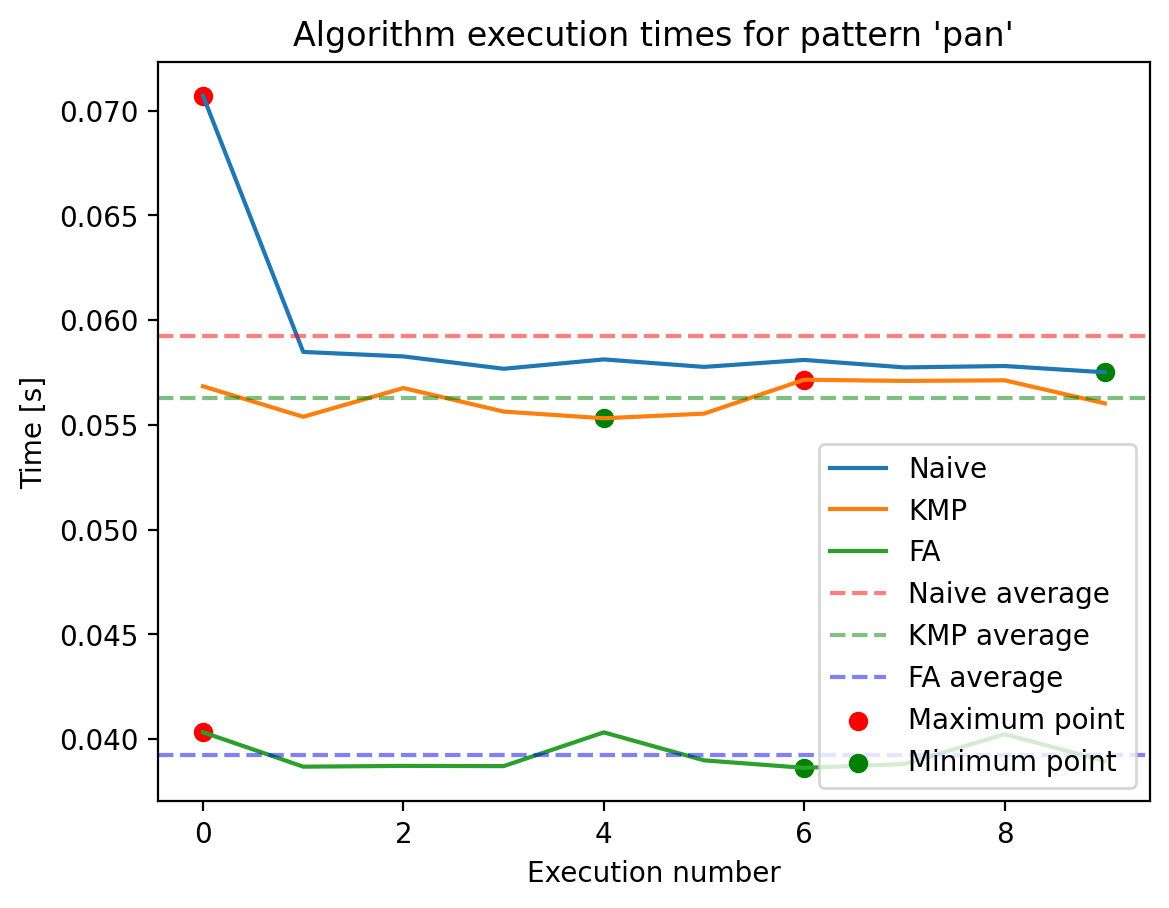

                        Minimum time [s]  Maximum time [s]  Average time [s]
Naive                       5.750637e-02          0.070703          0.059216
KMP pre-processing          7.919734e-07          0.000005          0.000002
KMP                         5.531137e-02          0.057151          0.056283
KMP with preprocessing      5.531217e-02          0.057152          0.056285
FA pre-processing           8.665986e-06          0.000021          0.000013
FA                          3.861783e-02          0.040309          0.039224
FA with preprocessing       3.862662e-02          0.040326          0.039237


In [10]:
print(show_algorithm_times(text, "pan"))

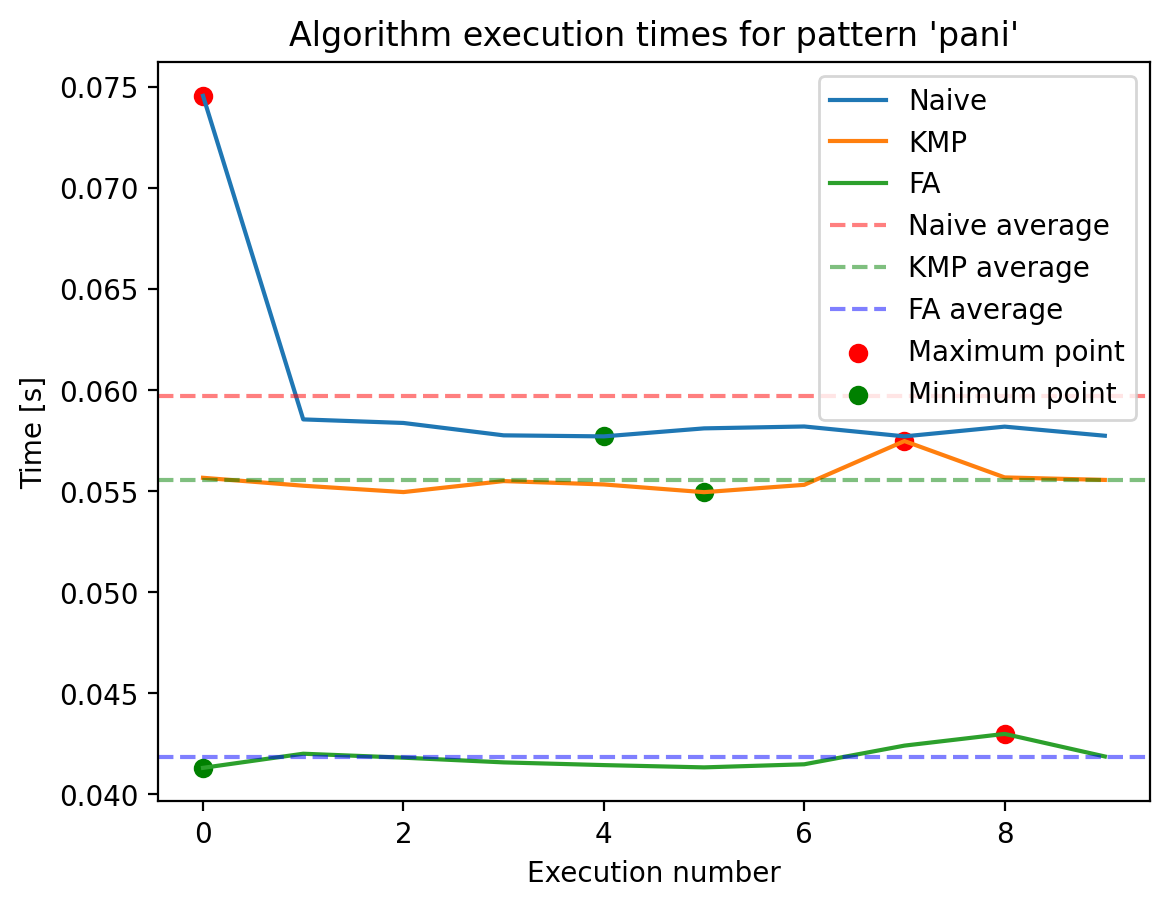

                        Minimum time [s]  Maximum time [s]  Average time [s]
Naive                       5.770958e-02          0.074556          0.059690
KMP pre-processing          8.330098e-07          0.000006          0.000002
KMP                         5.494883e-02          0.057477          0.055567
KMP with preprocessing      5.494975e-02          0.057479          0.055569
FA pre-processing           1.645798e-05          0.000033          0.000022
FA                          4.128250e-02          0.042960          0.041805
FA with preprocessing       4.131258e-02          0.042992          0.041827


In [12]:
print(show_algorithm_times(text, "pani"))

## Propozycja tekstu oraz wzorca, dla którego czas działania algorytmu KMP oraz automatu skończonego będzie co najmniej 5-krotnie krótszy niż dla algorytmu naiwnego (nie uwzględniając czasu pre-processingu).

In [17]:
example_text = "abc" * 1000000
example_pattern = "d" * 10000

naive_execution_time = measure_execution_time(Algorithm.NAIVE, example_text, example_pattern)[1]
kmp_execution_time = measure_execution_time(Algorithm.KMP, text, example_text)[1]
fa_execution_time = measure_execution_time(Algorithm.FA, text, example_pattern)[1]

print(pd.DataFrame({
    "Naive execution time [s]": [naive_execution_time],
    "KMP execution time [s]": [kmp_execution_time],
    "FA execution time [s]": [fa_execution_time],
    "Naive and KMP ratio": [naive_execution_time / kmp_execution_time],
    "Naive and FA ratio": [naive_execution_time / fa_execution_time],
}, index=['']))

  Naive execution time [s]  KMP execution time [s]  FA execution time [s]  \
                   1.15303                 0.06142                0.03156   

  Naive and KMP ratio  Naive and FA ratio  
             18.77292           36.534815  


## Wnioski z przeprowadzonych eksperymentów 

W trakcie eksperymentów najkrótsze czasy wykonywania osiągał algorytm automatu skończonego, zaraz po nim algorytm KMP, a najwolniejszym algorytmem okazał się algorytm naiwny. Zatem algorytm naiwny nie jest dobrym podejściem do wykrywania wzorców. Ciekawą obserwacją jest dość duża różnica czasów algorytmów KMP oraz autmatu skończonego. Dla powyższego podpunktu algorytm automatu skończonego działał 2 razy szybciej niż algorytm KMP. Wynika to z samej konstrukcji algorytmów. Automat skończony wykorzystuje tablicę przejść, która jest wypełniona na podstawie wzorca. Dla każdego znaku wykonuje stałą liczbę operacji (pobiera jedną wartość z tablicy przejść która jest np. słownikiem). W przypadku algorytmu KMP, dla jednego znaku może wykonać się więcej niż jedna operacja, ze względu na "przesuwanie" wzorca (gdy badany znak jest różny od wzorca, wzorzec jest przesuwany dopóki nie napotka się znaku równego badanemu). Minusem struktury wykorzystywanej dla algorytmu automatu skończonego jest duża ilość pamięci potrzebna do jej zapisania. W przypadku algorytmu KMP, potrzebna jest tylko tablica przejść, której długość jest równa długości szukanego wzorca. Dlatego też algorytm KMP jest bardziej wydajny pod względem pamięciowym. 